## Project Group - 31

Members (student number): 
- Gijs de Werd          (4717775)
- Georges Puttaert      (4686160)
- Thijs Roolvink        (4961382)
- Jim van Oosten        (4734998)

A link to the Github Repository: https://github.com/jimvanoosten/TIL6022_Group31

## Contribution Statement

**Gijs de Werd**: Setting up project and doing the Data analysis, coding data preparation

**Georges Puttaert**: Visualization general plots and coding of the data

**Thijs Roolvink**: Conceptualization, coding of the in depth plots

**Jim van Oosten**: Background research, coding conclusion

## Research Objective

**Hypotheses**: 

The hypothesis is that lower income classes can be very depended on flight with passengers and tourism and that gdp is dependent on these factors, lower income countries.

**Main question**: 

"How do air passenger volume, GDP, and tourism numbers interrelate from 2010 to 2020, and what do these interrelationships reveal about the economic resilience in terms of clustering?"

**Sub questions**:
- 1: How have air passenger volume, GDP, and tourism numbers differ from 2010 to 2020 in general, and are there discernible patterns in their time series data across countries? 

- 2: How do the three key metrics – air passenger volume, GDP, and tourism numbers correlate with each other across countries? 

- 3: How do countries cluster together when analyzed based on air passenger volume, GDP, and tourism data, and what common aspects can be identified within these clusters that hint at their economic resilience? 

- 4: In the identified clusters, how do member countries' key metrics distribute, and how do their correlation heatmaps compare to our initial hypotheses? 


**SHORT DESCIPTION OF THE RESEARCH PROJECT**:

We want to begin high level, so tell something about the three factors, then show the timeseries for visualization. After that we want to dive deeper in the correlation between the three factors, so how they interrelate and make a few hypotheses about the correlations. Then we want to implement a K-means clustering to cluster the countries into 3 groups. Then after the clusters are formed, we check boxplots per cluster the see how the data is per boxplot and a hierachical clustering per cluster. Analyze it and state that there can be differences in comparison with the hypotheses. Also heatmaps for each cluster will be implemented for all 3 factors, Traffic, GDP and Tourism. All the visualization will be displayed in a dashboard.

(*some answers already for a quick overview*:
- *The clustering algorithm can cluster countries based on these factors*
- *There can be seen that luxembourg do not care if lower passengers or tourism, gdp still stays high*
- *The lower income countries can be determined with the kmeans and there can be seen that Italy, Spain, France and Germany indeed need tourism and passengers, can be clearly seen*
- *AT, BE, DK, FI, LU, NL, SE: These are high income classes and are clustered together based on the criteria.*)

## Data Used

GDP per capita, quarterly data to monthly: https://ec.europa.eu/eurostat/databrowser/view/namq_10_gdp/default/table?lang=en \
Commercial flights by reporting airport – monthly data: https://ec.europa.eu/eurostat/databrowser/view/avia_paoc__custom_7863778/default/line?lang=en \
Arrivals at tourist accommodation establishments - monthly data: https://ec.europa.eu/eurostat/databrowser/product/view/tour_occ_nim \
World Bank’s databases about Sustainable Development Goals, by using the wbdata library - https://wbdata.readthedocs.io/en/latest/index.html

## Data Pipeline

## 1. Introduction

From the year 2010 to 2020, the aviation sector showed a rapid increase in air passengers and the tourism sector flourished influencing the global GDP. Countries in the EU are influenced by the number fluctuations regarding the air passengers, tourism, and GDP per capita. Where lower-income countries are being more vulnarable to disruptions in air passengers and tourism, whereas higher income countries tend be more resilient. Countries as Italy and Spain depend highly on air passengers and tourism. This study aims to deep dive into the interrealtion between the three factors in the EU countries. Using data from a decade before the COVID-19 pandamic, since biased results are generated. Throughout data analysis and unsupervised clustering methods, pattern are uncovered highlighting the economic behaviors of countries in response to air passengers, tourism and GDP. The EU countries are clustered based on these pattern are will show significant interrelations which can be linked to the social and income class of a country. 

## 2. Data preperation

In [3]:
# pip install pandas matplotlib scikit-learn scipy numpy seaborn plotly country-converter wbdata

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import scipy.stats as stats
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
import country_converter as coco
import plotly.express as px
import wbdata
import warnings

In [5]:
traffic = pd.read_csv('Datasets/air_passengers_from2000.csv')
tourism = pd.read_csv('Datasets/tourism_from2000.csv')
gdp = pd.read_csv('Datasets/gdp_from2000.csv')

In [6]:
def quarter_to_month(quarter):
    year, qtr = quarter.split('-')
    if qtr == 'Q1':
        return [f'{year}-01', f'{year}-02', f'{year}-03']
    elif qtr == 'Q2':
        return [f'{year}-04', f'{year}-05', f'{year}-06']
    elif qtr == 'Q3':
        return [f'{year}-07', f'{year}-08', f'{year}-09']
    else: # 'Q4'
        return [f'{year}-10', f'{year}-11', f'{year}-12']

mask = gdp['TIME_PERIOD'].str.match(r'\d{4}-Q[1-4]$')
gdp.loc[mask, 'TIME_PERIOD'] = gdp.loc[mask, 'TIME_PERIOD'].apply(quarter_to_month)
gdp = gdp.explode('TIME_PERIOD')

In [7]:
# Make a database 
traffic = traffic.rename(columns={'OBS_VALUE': 'Traffic'})
tourism = tourism.rename(columns={'OBS_VALUE': 'Tourism'})
gdp = gdp.rename(columns={'OBS_VALUE': 'GDP'})


traffic_filtered = traffic[
    (traffic['tra_meas'] == 'PAS_BRD') &
    (traffic['TIME_PERIOD'] >= '2010-01') & 
    (traffic['TIME_PERIOD'] <= '2020-01')                   
]

tourism_filtered = tourism[
    (tourism['unit'] == 'NR') &
    (tourism['nace_r2'] == 'I551') &
    (tourism['c_resid'] == 'TOTAL') &
    (tourism['TIME_PERIOD'] >= '2010-01') &
    (tourism['TIME_PERIOD'] <= '2020-01')
]

gdp_filtered = gdp[
    (gdp['unit'] == 'CP_EUR_HAB') &
    (gdp['s_adj'] == 'NSA') &
    (gdp['na_item'] == 'B1GQ') &
    (gdp['TIME_PERIOD'] >= '2010-01') &
    (gdp['TIME_PERIOD'] <= '2020-01')
]

In [8]:
# Merge the dataset into 1 big dataset
countries = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "EL", "ES", "FI", "FR", "HR", "HU", 'UK', "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]

traffic_filtered = traffic_filtered[traffic_filtered['geo'].isin(countries)]
tourism_filtered = tourism_filtered[tourism_filtered['geo'].isin(countries)]
gdp_filtered = gdp_filtered[gdp_filtered['geo'].isin(countries)]


merged_data = pd.merge(traffic_filtered[['TIME_PERIOD', 'geo', 'Traffic']], 
                       gdp_filtered[['TIME_PERIOD', 'geo', 'GDP']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

merged_data = pd.merge(merged_data,
                       tourism_filtered[['TIME_PERIOD', 'geo', 'Tourism']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

In [9]:
# Prepare data for usage of the World Bank data package
countries_df = pd.DataFrame()
countries_df['country'] = countries
cc = coco.CountryConverter()
countries_df['country'] = countries_df['country'].replace('EL', 'GR')
countries_df['country'] = cc.pandas_convert(series=countries_df['country'], to='ISO3')
countries_df['country names'] = cc.convert(names=countries_df['country'], to="name")

## 3. Visualization

### Difference in GNI within the EU countries
Below, the GNI (Gross National Income) per capita for all Europian Union countries for the years 2010 and 2020 are given. This data is published by the worldbank, World development indicators database. This bar plot gives a first impressions on the GNI differnces between European countries and visualizes the European average. 

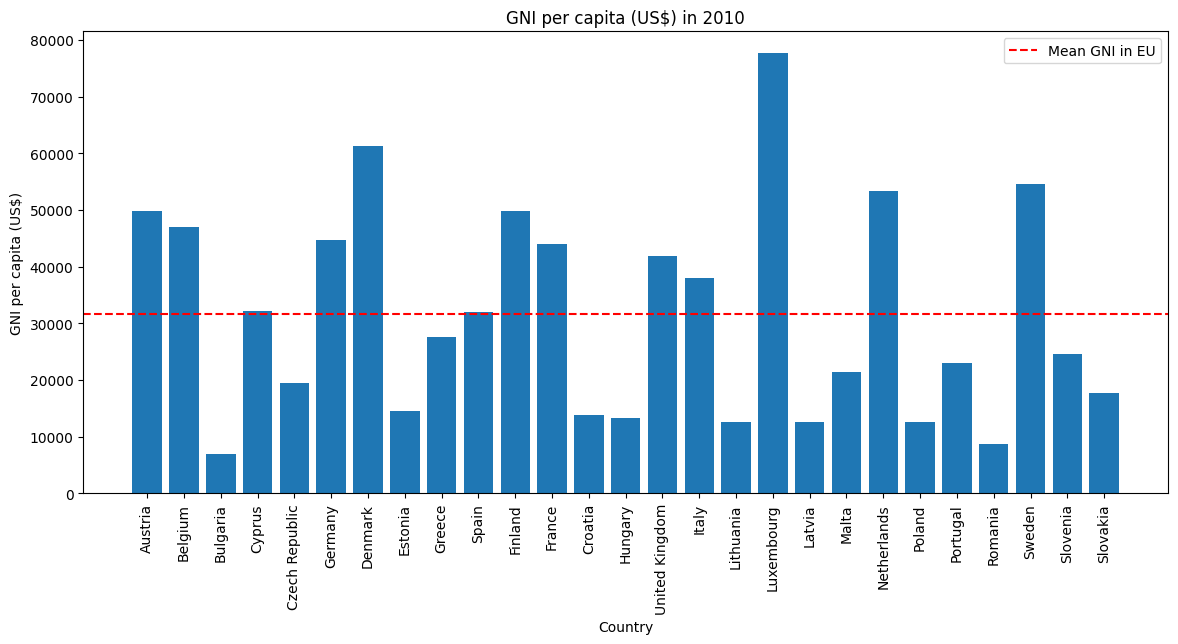

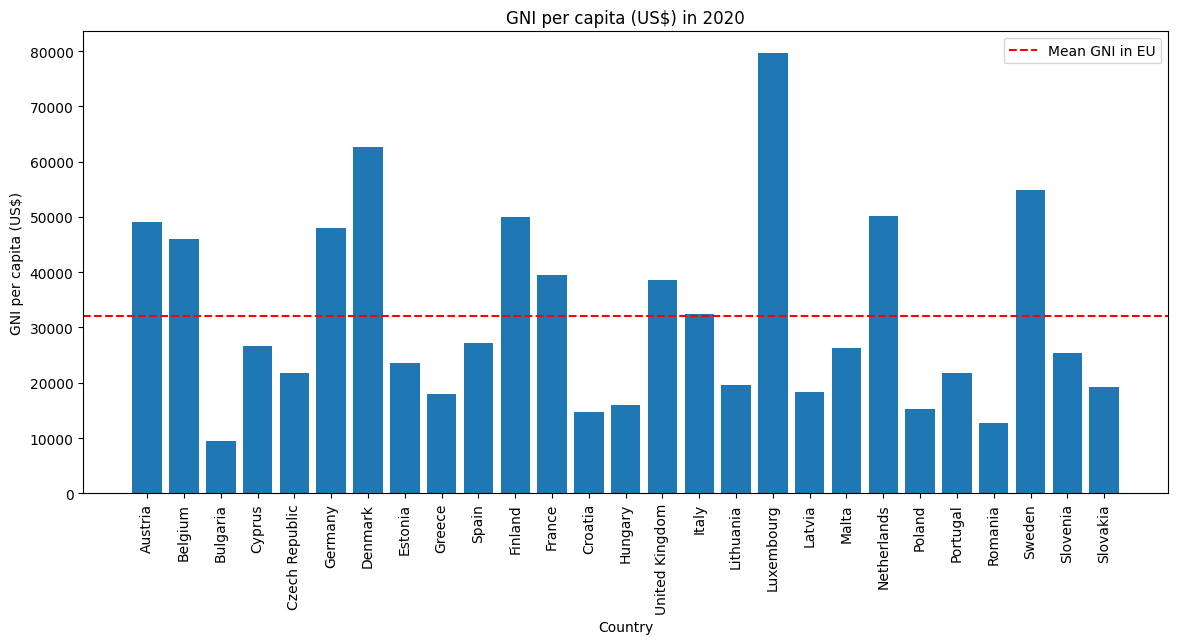

In [10]:
Indicator = "GNI per capita (US$)"
indicator_code = {'NY.GNP.PCAP.CD': 'GNI per capita (US$)'}
years = ['2010', '2020']

for year in years:
    countries_df[year] = 0

for i in range(len(countries_df)):
    for j in years:
        data = wbdata.get_dataframe(indicator_code, country=countries_df['country'][i])
        value = data['GNI per capita (US$)'][f'{j}']
        countries_df.loc[i, f'{j}'] = value

for year in years:
    plt.figure(figsize=(14, 6))
    plt.bar(countries_df['country names'], countries_df[year])
    plt.axhline(countries_df[f'{year}'].mean(), color='red', linestyle='--', label='Mean GNI in EU')
    plt.xlabel('Country')
    plt.ylabel(f'{Indicator}')
    plt.title(f'{Indicator} in {year}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

### Time series interactive plot of for all European countries and factors (default option is no country)

In [11]:
merged_data = merged_data.sort_values(by=['geo', 'TIME_PERIOD'])

fig = go.Figure()

# Scatter for Traffic
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['Traffic'],
        mode='lines',
        name=f"Traffic {country}",
        visible="legendonly"
    ))

# Scatter forTourism
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['Tourism'],
        mode='lines',
        name=f"Tourism {country}",
        visible="legendonly"
    ))

# Scatter for GDP
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['GDP'],
        mode='lines',
        name=f"GDP {country}",
        yaxis="y2",  
        visible="legendonly"
    ))

fig.update_layout(
    title='Traffic, Tourism, and GDP (2010-2022)',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Traffic/Tourism Value'),
    yaxis2=dict(title='GDP Value', overlaying='y', side='right', title_standoff=25), 
    showlegend=True,
    legend=dict(x=1.05)
)

fig.show()


### Correlation heatmap and time series interactive dashboard

For the correlation heatmap and the timeseries Dashboard for each country, please visit:

http://127.0.0.1:8051/

## 4. Unsupervised learning: Kmeans clustering

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data[['Traffic','Tourism', 'GDP']])

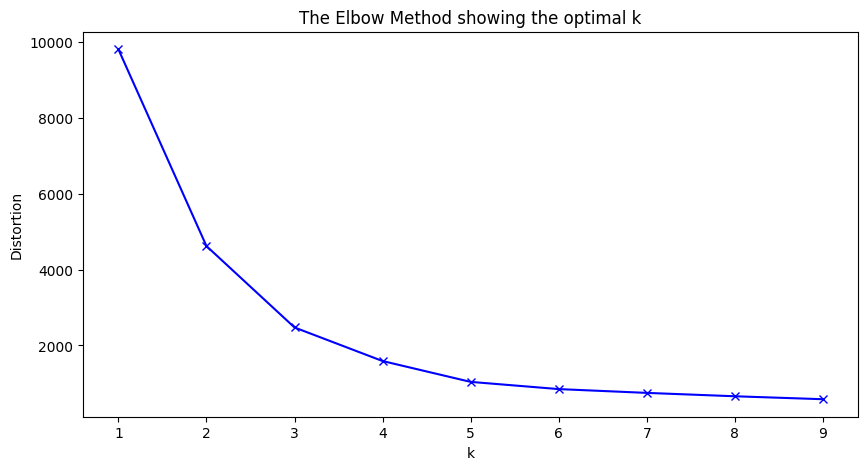

In [21]:
# Determine the number of clusters (using Elbow method as an example)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_data)
    distortions.append(kmeanModel.inertia_)
    warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [14]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
merged_data['Cluster'] = clusters

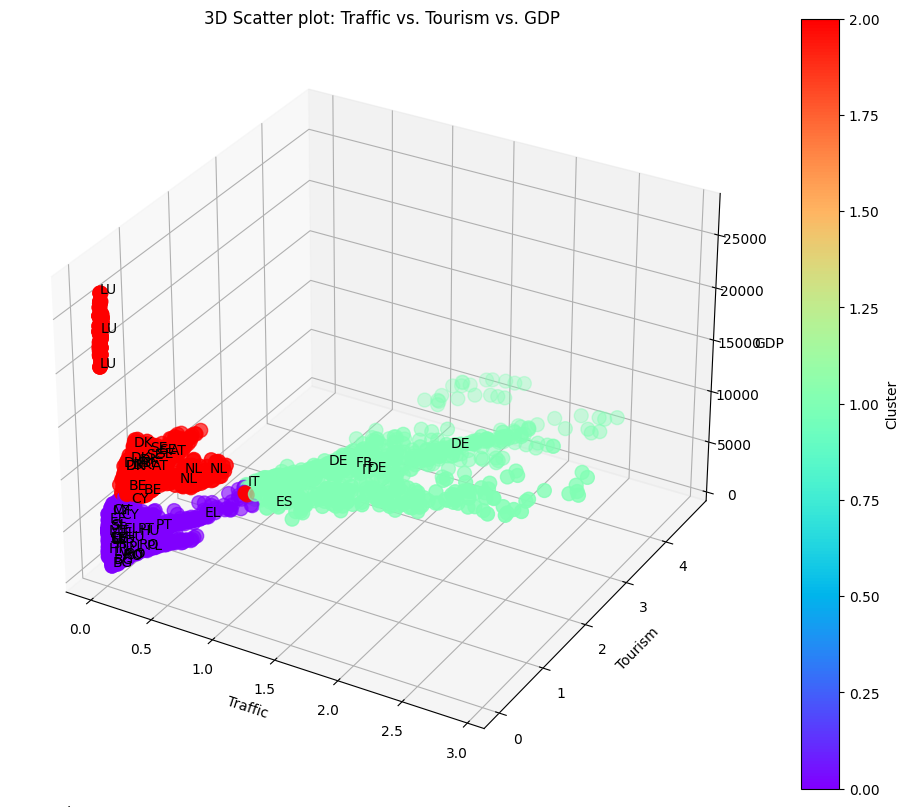

In [15]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(merged_data['Traffic'], merged_data['Tourism'], merged_data['GDP'], c=merged_data['Cluster'], cmap='rainbow', s=100)

# for idx, row in merged_data.iterrows():
#     ax.text(row['Traffic'], row['Tourism'], row['GDP'], row['geo'])

for i, row in merged_data.iterrows():
    if np.random.rand() < 0.02:  # Only annotate 10% of the points
        ax.text(row['Traffic'], row['Tourism'], row['GDP'], row['geo'])

ax.set_xlabel('Traffic')
ax.set_ylabel('Tourism')
ax.set_zlabel('GDP')
ax.set_title('3D Scatter plot: Traffic vs. Tourism vs. GDP')

fig.colorbar(sc).set_label('Cluster')

plt.show()


In [16]:
def mode_cluster(x):
    mode, _ = stats.mode(x)
    return mode[0]

country_clusters = merged_data.groupby('geo')['Cluster'].apply(mode_cluster).reset_index()
cluster = {}
for cluster_num in range(k):
    print(f"Cluster {cluster_num}: {', '.join(country_clusters[country_clusters['Cluster'] == cluster_num]['geo'].tolist())}")
    cluster[cluster_num] = country_clusters[country_clusters['Cluster'] == cluster_num]['geo'].tolist()

Cluster 0: BG, CY, CZ, EE, EL, HR, HU, LT, LV, MT, PL, PT, RO, SI, SK
Cluster 1: DE, ES, FR, IT, UK
Cluster 2: AT, BE, DK, FI, LU, NL, SE


### Boxplot per cluster 

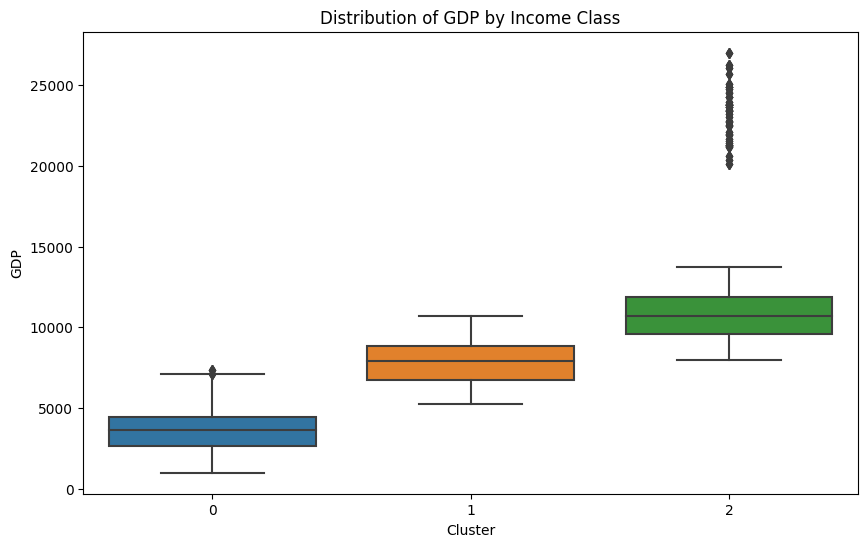

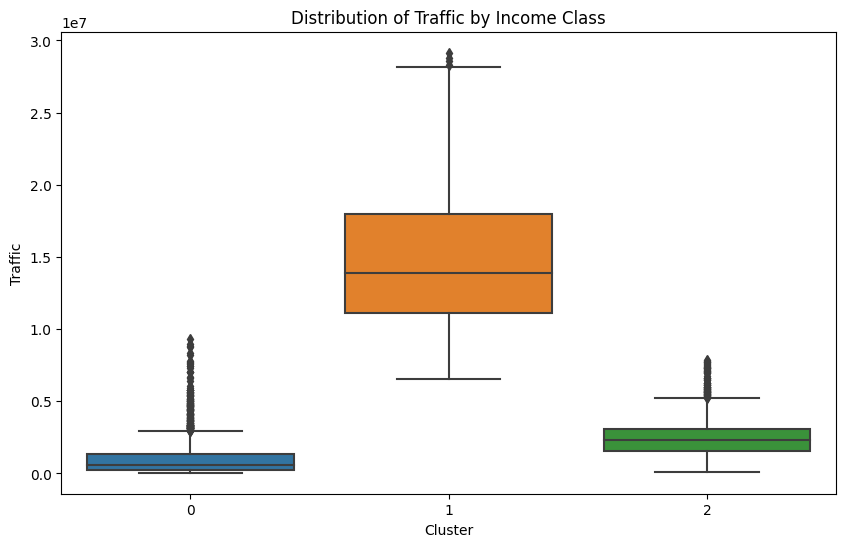

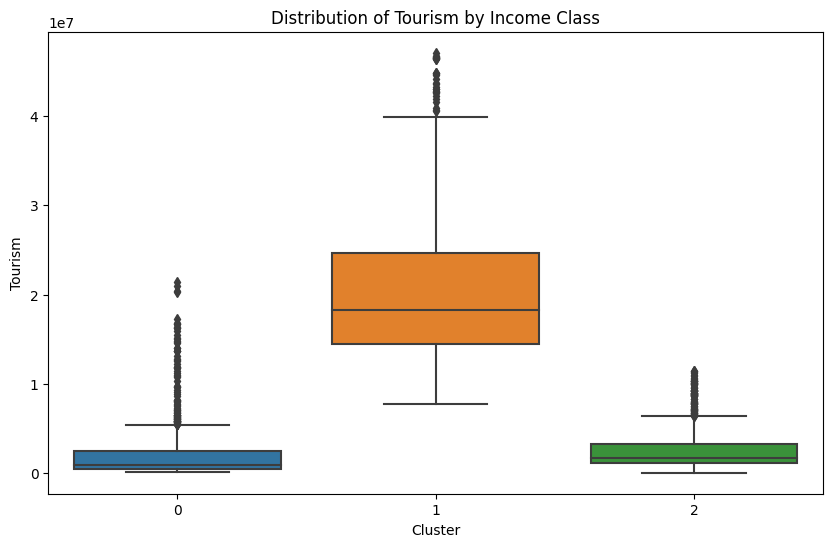

In [17]:
country_to_cluster = {country: cluster for cluster, countries in cluster.items() for country in countries}
merged_data['Income Class'] = merged_data['geo'].map(country_to_cluster)
metrics = ['GDP', 'Traffic', 'Tourism']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Income Class', y=metric, data=merged_data)
    plt.title(f'Distribution of {metric} by Income Class')
    plt.ylabel(metric)
    plt.xlabel('Cluster')
    plt.show()

- **Cluster 0 (15 countries)**: These countries are the smallest in terms of GDP, tourism, and air passengers.

- Cluster 0 (15 countries): These countries are the smallest in terms of GDP, tourism, and air passengers.
    - GDP: These nations might be developing or have smaller economies in comparison to the other two clusters.
    - Tourism: They have emerging tourist destinations or destinations that might be popular locally or regionally but not as internationally renowned.
    - Air Passengers: They see fewer international passengers, likely due to having fewer international airports or fewer connections to major global hubs. 


- **Cluster 1 (5 countries)**: These are the top performers in all three categories, signifying their importance both in Europe and globally.

    - GDP: Being some of the largest economies in Europe, they play a pivotal role in global economic activities.
    - Tourism: These are top tourist destinations, attracting a vast majority of international tourists due to their diverse attractions.
    - Air Passengers: Serving as significant hubs for international travel, these countries likely have multiple major international airports.

- **Cluster 2 (7 countries)**: These countries are in between the other two clusters in all categories, signifying their robust yet not dominant position.

    - GDP: While not as high as Cluster 1, these countries still have strong economies, possibly with a high GDP per capita.
    - Tourism: Catering to both mainstream and niche tourist markets, they have a significant number of tourists but not as much as Cluster 1.
    - Air Passengers: They have good connectivity and might serve as secondary hubs in Europe, but they don't see as much traffic as the countries in Cluster 1.

### Hierachical Clustering

A Hierachical Clustering is used to visualize the dendrogram of each cluster for each factor (Traffic, Tourism and GDP). The dendogram reveals the similarity in terms of the factors. The 'Distance' in the X-axis can be interpreted as a measure of dissimilarity. The lower the distance at which two countries merge in the dendrogram, the more similar they are.

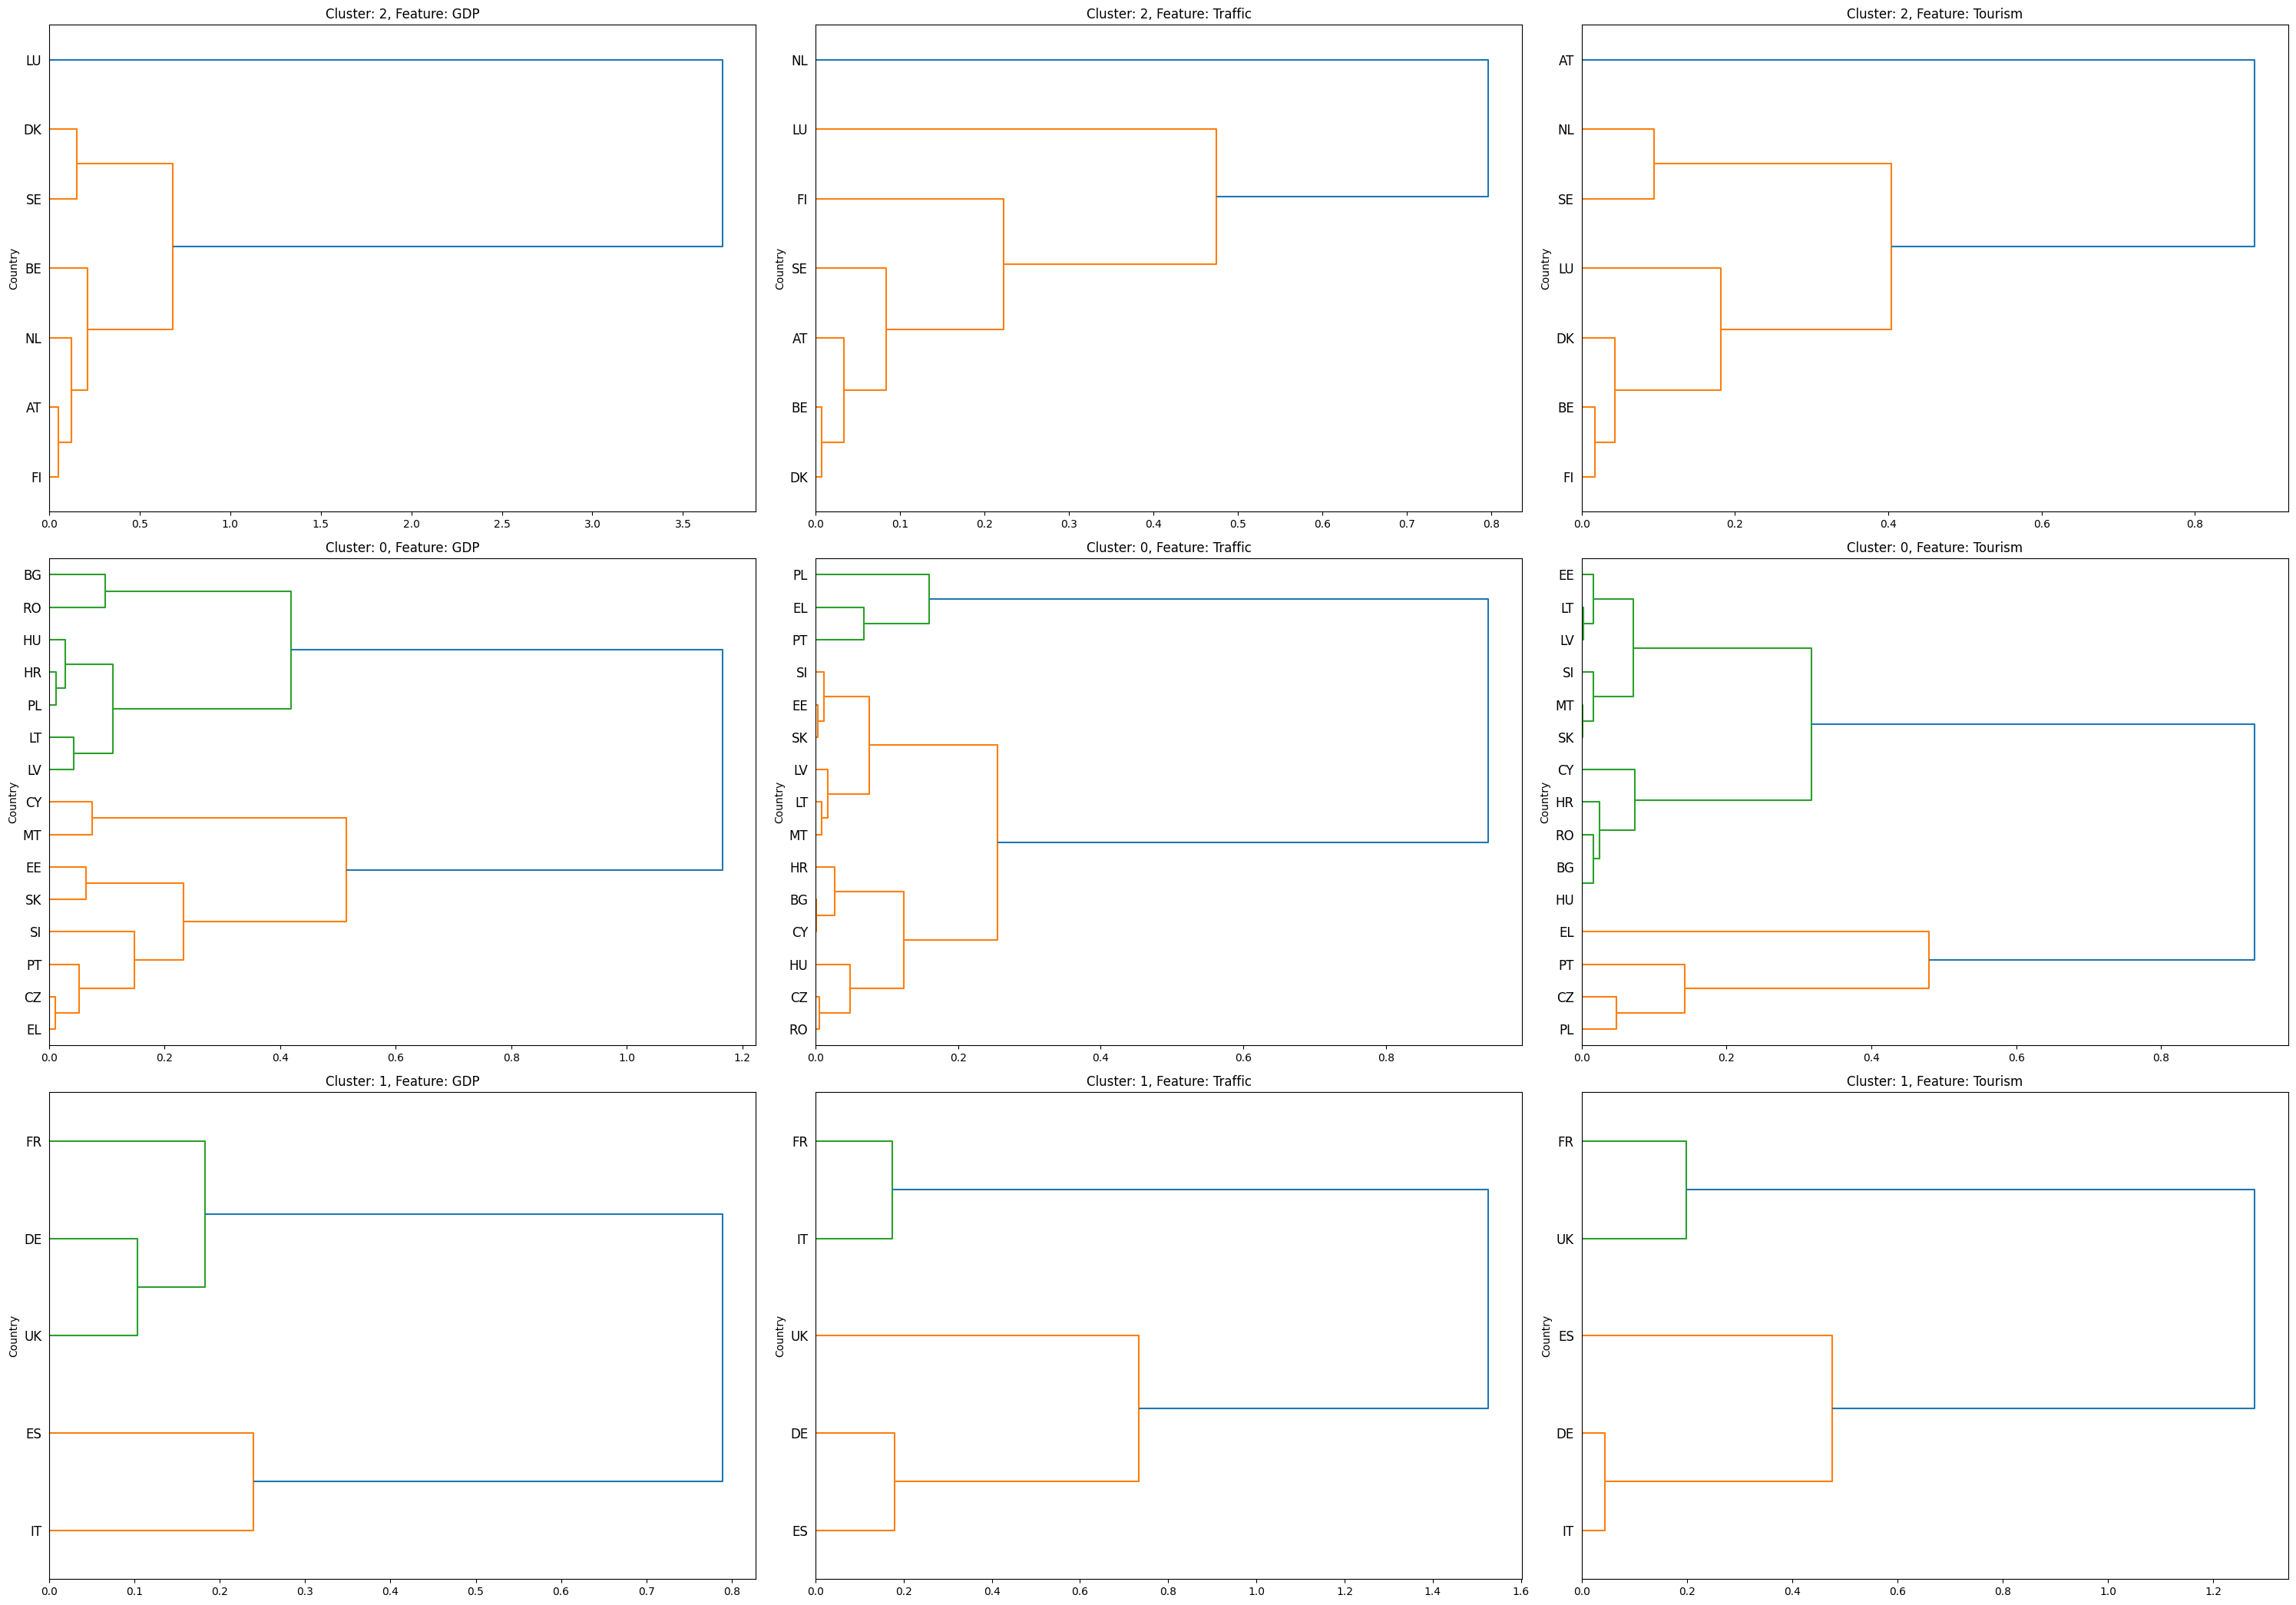

In [18]:
scaler = StandardScaler()
scale_cols = ['GDP','Traffic', 'Tourism']

merged_data_scaled = merged_data.copy()
merged_data_scaled[scale_cols] = scaler.fit_transform(merged_data_scaled[scale_cols])

# Create a set of unique income classes
income_clusters = merged_data_scaled['Income Class'].unique()

plt.figure(figsize=(30, 7 * len(income_clusters)))
for i, cluster in enumerate(income_clusters):
    sub_df = merged_data_scaled[merged_data_scaled['Income Class'] == cluster]
    mean_sub_df = sub_df.groupby('geo')[scale_cols].mean()
    for j, col in enumerate(scale_cols):
        plt.subplot(len(income_clusters), len(scale_cols), i * len(scale_cols) + j + 1)
        # Perform hierarchical clustering
        linked = linkage(mean_sub_df[[col]], method='ward')
        
        # Plot the dendrogram
        plt.title(f'Cluster: {cluster}, Feature: {col}')
        dendrogram(linked, orientation='right', distance_sort='descending', labels=mean_sub_df.index)
        plt.ylabel('Country')
        
plt.tight_layout()
plt.show()

### Map

In [19]:
cc = coco.CountryConverter()
merged_data['geo'] = merged_data['geo'].replace('EL', 'GR')
iso3_codes = cc.pandas_convert(series=merged_data['geo'], to='ISO3')
merged_data['geo_ISO_3'] = iso3_codes

In [20]:
for i, cluster in enumerate(income_clusters):
    sub_df = merged_data[merged_data['Income Class'] == cluster]
    for j, col in enumerate(scale_cols):
        fig = px.choropleth(
            sub_df,
            locations='geo_ISO_3',
            locationmode='ISO-3',
            color=col,
            hover_name='geo',
            animation_frame='TIME_PERIOD',
            title= str(col) + ' of European Countries of Cluster ' + str(cluster) + ' from 2010 to 2020',
            scope='europe',
            color_continuous_scale=px.colors.sequential.Emrld,
            range_color = (min(sub_df[col]), max(sub_df[col])),
            height = 1000, 
            width = 750
        )

        # Adjust the slider properties
        sliders_dict = {
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 15},
                'prefix': 'Year:',
                'visible': True,
                'xanchor': 'right'
            }
        }

        fig.update_layout(sliders=[sliders_dict])
        fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
        fig.update_geos(fitbounds="locations")
        fig.show()

## 5. Conclusion and discussion

some answers:
- *The clustering algorithm can cluster countries based on these factors*
- *There can be seen that luxembourg do not care if lower passengers or tourism, gdp still stays high*
- *The lower income countries can be determined with the kmeans and there can be seen that Italy, Spain, France and Germany indeed need tourism and passengers, can be clearly seen*
- *AT, BE, DK, FI, LU, NL, SE: These are high income classes and are clustered together based on the criteria.*
-  Can be seen that in countries like Bulgaria: the gdp, air passengers and tourism relate to each other, all low and all high. For France, Belgium for example you see that this isnt the story because GDP is relatively lower when tourism and air passengers are relatively higher.

Through this research, the complexities of interrelations between flight volume, GDP growth, and tourism numbers from 2010 to 2020 have been examined with a focus on their implications for economic resilience across varying income classes.

The adoption of clustering algorithms, particularly K-means, has proven instrumental in unveiling patterns and relationships based on the three selected economic indicators. By observing the clusters formed, it became evident how countries inherently align or diverge based on their dependency or independence on these factors.

Countries such as Luxembourg displayed a unique clustering pattern, indicating a relative economic independence from the aviation and tourism sectors. This is contrasted by countries like Italy, Spain, France, and Germany, whose economic well-being demonstrated a stronger reliance on tourism and aviation, as reflected in their cluster grouping.

When viewing the broader landscape of high-income countries, there's a clear pattern of clustering based on flight volume, tourism, and GDP metrics, underscoring their economic interdependencies. Notably, countries like AT, BE, DK, FI, LU, NL, and SE were found to cluster together, solidifying the findings.

The results underscore the power of data-driven clustering techniques in shedding light on intricate economic dynamics and providing nuanced understandings of country-specific economic behaviors. Such insights can guide policymakers and stakeholders in shaping economic strategies that are both responsive and adaptive to changing global trends.

## References